# Sign-Language Detection using CNN and Landmark Detection
2502003775 - ERIN KUMALA ALIWARGA\
2501985451 - JASON ADRIEL\
2501987091 - MOETHIA SHAKIRA\
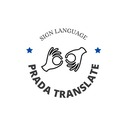

#Introduction
Bahasa Isyarat adalah bahasa yang mengutamakan komunikasi manual, bahasa tubuh, dan gerak bibir. Bahasa isyarat merupakan bahasa yang digunakan oleh tuna rungu / tuli / hard-of-hearing untuk berkomunikasi. Tidak hanya itu, bahasa isyarat juga merupakan alat bagi penggunanya untuk mengidentifikasi diri dan memperoleh informasi.

Namun, terdapat hambatan linguistik dan budaya pada bahasa isyarat yang menimbulkan tantangan dalam berkomunikasi antara pengguna bahasa isyarat dan non-pengguna. Untuk mengatasinya, kelompok kami mencoba membuat sebuah model AI yang dapat menerjemahkan bahasa isyarat.

Sistem pengenalan bahasa isyarat memanfaatkan computer vision, machine learning, dan artificial intelligence untuk mengubah gerakan bahasa isyarat menjadi huruf.

# Model
Terdapat dua model yang dibuat, pertama adalah model CNN yang static-image based, sehingga hanya melihat pixel gambar, dan model kedua adalah model Random Forest yang landmark-based, model campuran yang menggunakan deteksi landmark tangan di library Mediapipe dan mencocokkannya dengan data training. Hasil model RF jauh lebih baik di skenario nyata dibandingkan CNN, walaupun hasil akurasinya lebih rendah di training.

Anda bisa menjalankan model ini jika terdapat sebuah webcam di komputer anda, mohon berikan akses 'Camera' kepada Google Colab agar dapat menjalankannya. Pastikan semua cell sudah berjalan sebelum menjalankan fungsi run().\
[Klik disini dan jalankan cell untuk mencoba model.](#run)

# 0. Library Setup and Data Loading

Dataset used: https://www.kaggle.com/datasets/datamunge/sign-language-mnist

In [ ]:
#Installs
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 62.7 MB/s eta 0:00:00


In [ ]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

#Setup
plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large',
       titleweight = 'bold', titlesize = 14, titlepad = 12)
sns.set_style("whitegrid")

In [ ]:
df_train = pd.read_csv("https://raw.githubusercontent.com/intll/datasets/main/sign_mnist_train.csv")
df_test  = pd.read_csv("https://raw.githubusercontent.com/intll/datasets/main/sign_mnist_test.csv")

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


# 1. Data Exploration

In [ ]:
df_train.isna().sum().value_counts()

0    785
dtype: int64

In [ ]:
df_train.duplicated().sum()

0

In [ ]:
#The ninth label is not included in the dataset since 'J' is a dynamic
#movement sign, not static.
print(sorted(df_train["label"].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [ ]:
#The image data is a 28x28 in size,
def previewImage(df):
  '''
  Function to preview the first 15 images in the dataset with their corresponding
  signed letters. The labels are encoded as {0 : 'A', 1 : 'B', ...} and so on.
  '''
  fig, axes = plt.subplots(3, 5, figsize = (8, 8))
  axes = axes.flatten()
  for i in range(15):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    axes[i].imshow(img, cmap = "gray")
    axes[i].set_title(chr(ord('A') + df.iloc[i, 0]))

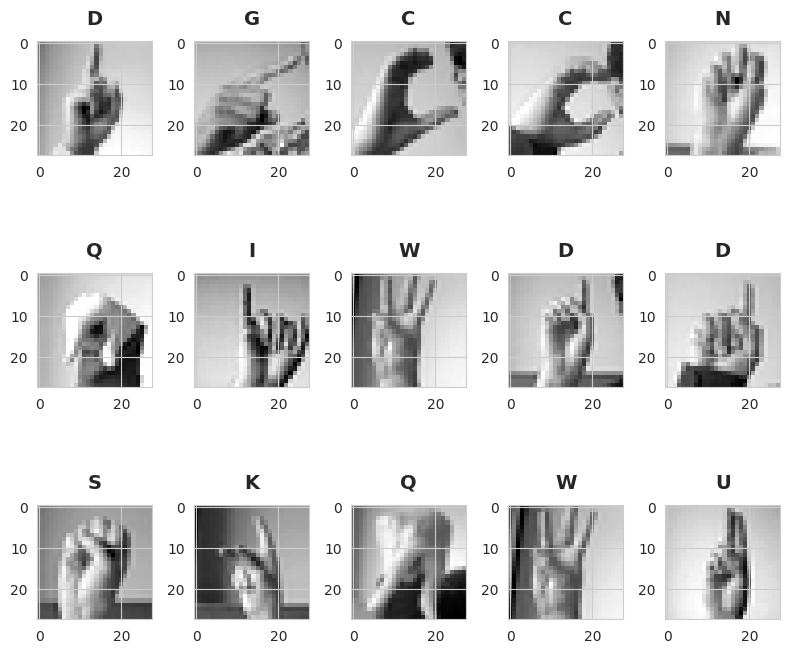

In [ ]:
previewImage(df_train)

In [ ]:
def viewLabels(df):
  '''
  Function to show the distribution of the labels of the dataset.
  '''
  c = df.copy()
  c['label'] = [chr(ord('A') + x) for x in c['label']]
  sns.countplot(x = c['label'], order = c['label'].value_counts().index, palette = "viridis")
  plt.title("Label Samples Distribution")

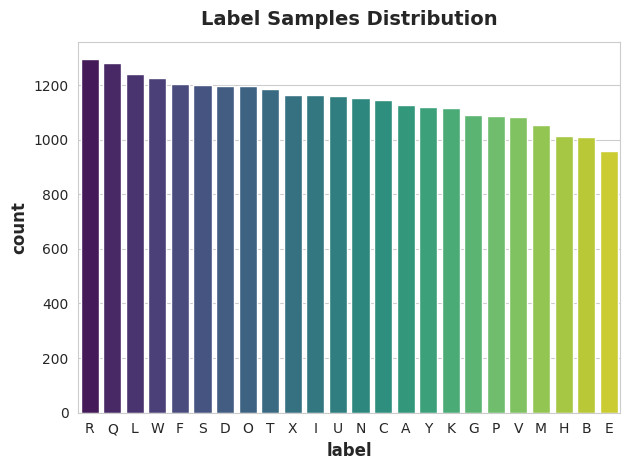

In [ ]:
viewLabels(df_train)

#2. Data Preprocessing

In [ ]:
#Separate the data to x_train, y_train, x_val, and y_val
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df_train.drop("label", axis = 1),
                                                    df_train["label"],
                                                    test_size = 0.2,
                                                    random_state = 1)
print(f"Training data size   : {len(x_train)}")
print(f"Validation data size : {len(x_val)}")

Training data size   : 21964
Validation data size : 5491


In [ ]:
#A CNN requires (height, width, color_channels), we need to reshape the data to a tensor
x_train = tf.reshape(x_train, [-1, 28, 28, 1])
x_val   = tf.reshape(x_val,   [-1, 28, 28, 1])
print(tf.shape(x_train))
print(tf.shape(x_val))

tf.Tensor([21964    28    28     1], shape=(4,), dtype=int32)
tf.Tensor([5491   28   28    1], shape=(4,), dtype=int32)


# 3. Convolutional Neural Network Model

## 3.1 Creating a CNN Model

In [ ]:
from tensorflow import keras
from keras import layers

baseline_model = keras.Sequential([
    layers.InputLayer(input_shape = [28, 28, 1]),

    #Augment the Data with Random Changes
    layers.RandomContrast(factor = 0.15),
    layers.RandomTranslation(height_factor = 0.2, width_factor = 0.2),

    #Create Convolution Block #1:
    layers.BatchNormalization(renorm = True),
    layers.Conv2D(filters = 16, kernel_size = 2, activation = 'relu', padding = 'same'),
    layers.MaxPool2D(),

    #Dense Head
    layers.BatchNormalization(renorm = True),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(25, activation = 'softmax')
])

In [ ]:
baseline_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'],
)

In [ ]:
from keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001,
    patience = 10,
    restore_best_weights = True
)

results = baseline_model.fit(x_train,
                             y_train,
                             validation_data = (x_val, y_val),
                             batch_size = 512,
                             epochs = 100,
                             callbacks = [early_stopping]
                             )

Epoch 1/100
43/43 [==============================] - 7s 133ms/step - loss: 7.6761 - accuracy: 0.0624 - val_loss: 2.7790 - val_accuracy: 0.1878
Epoch 2/100
43/43 [==============================] - 6s 146ms/step - loss: 3.1002 - accuracy: 0.1615 - val_loss: 2.0154 - val_accuracy: 0.4464
Epoch 3/100
43/43 [==============================] - 9s 214ms/step - loss: 2.2734 - accuracy: 0.3113 - val_loss: 1.3804 - val_accuracy: 0.6055
Epoch 4/100
43/43 [==============================] - 10s 240ms/step - loss: 1.8825 - accuracy: 0.4171 - val_loss: 1.0281 - val_accuracy: 0.7028
Epoch 5/100
43/43 [==============================] - 11s 249ms/step - loss: 1.6142 - accuracy: 0.4915 - val_loss: 0.7966 - val_accuracy: 0.7645
Epoch 6/100
43/43 [==============================] - 7s 153ms/step - loss: 1.3864 - accuracy: 0.5534 - val_loss: 0.6254 - val_accuracy: 0.8104
Epoch 7/100
43/43 [==============================] - 5s 123ms/step - loss: 1.2099 - accuracy: 0.6103 - val_loss: 0.4916 - val_accuracy: 0.85

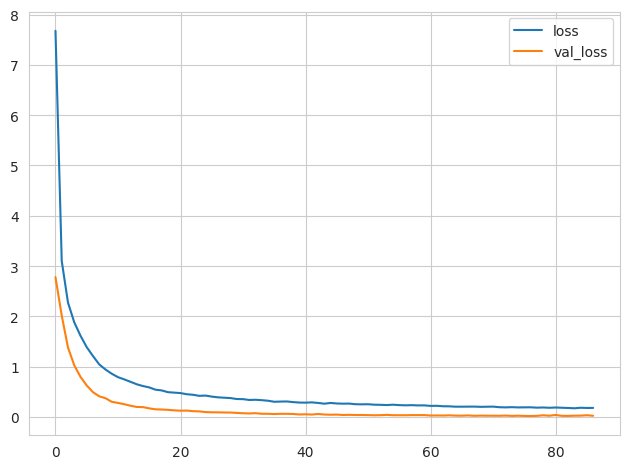

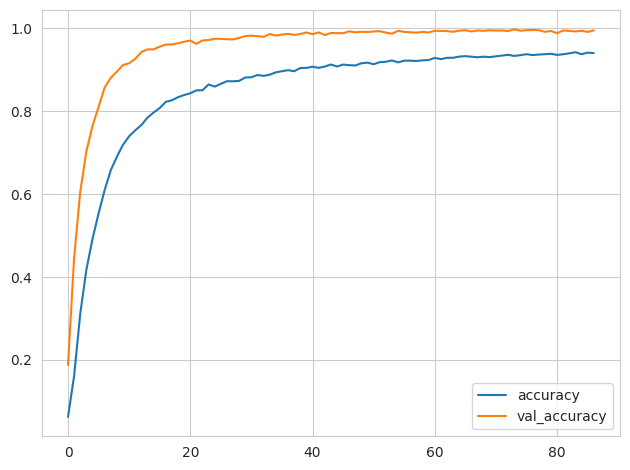

In [ ]:
train_results = pd.DataFrame(results.history)
train_results.loc[:, ['loss', 'val_loss']].plot()
train_results.loc[:, ['accuracy', 'val_accuracy']].plot();

## 3.2 Evaluation of Baseline Model

In [ ]:
x_test = tf.reshape(df_test.iloc[:, 1:], [-1, 28, 28, 1])
y_test = df_test['label']

In [ ]:
y_pred = np.argmax(baseline_model.predict(x_test), axis = 1)

225/225 [==============================] - 1s 4ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.97      0.99       432
           2       1.00      0.95      0.97       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      0.97      0.99       436
           8       1.00      1.00      1.00       288
          10       1.00      1.00      1.00       331
          11       1.00      1.00      1.00       209
          12       1.00      0.98      0.99       394
          13       0.99      1.00      0.99       291
          14       0.94      1.00      0.97       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       1.00      0.88      0.93       144
          18       0.92    

There are huge possibilities of overfitting, particularly due to the small 28x28 image size, this might not translate well in real life scenarios (which is the case, as seen in the real-life test result at the end).

## 3.3 Sign Recognition Using Landmark Detection Model

In [ ]:
import mediapipe
hands_model = mediapipe.solutions.hands.Hands(static_image_mode = True,
                                              model_complexity = 1,
                                              max_num_hands = 1,
                                              min_detection_confidence = 0.1)

In [ ]:
#Setting up the DataFrame
from tqdm import tqdm
import cv2

x_train_landmarks = []
y_train_landmarks = []
for i in tqdm(range(len(df_train))):
  pixels = np.array(df_train.iloc[i, 1:].values.reshape(28, 28), dtype = np.uint8)
  label = df_train.iloc[i, 0]
  img = cv2.cvtColor(pixels, cv2.COLOR_GRAY2RGB)

  results = hands_model.process(img).multi_hand_landmarks
  if results:
    features = []
    for landmarks in results:
      for i in range(len(landmarks.landmark)):
        features.append(landmarks.landmark[i].x)
        features.append(landmarks.landmark[i].y)
        x_train_landmarks.append(features)
        y_train_landmarks.append(label)

100%|██████████| 27455/27455 [17:04<00:00, 26.81it/s]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_landmarks,
                                                    y_train_landmarks,
                                                    test_size = 0.2,
                                                    random_state = 1)
print(f"Training data size   : {len(x_train)}")
print(f"Validation data size : {len(x_val)}")

Training data size   : 28240
Validation data size : 7061


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       554
           1       1.00      1.00      1.00       406
           2       1.00      1.00      1.00       109
           3       1.00      1.00      1.00       165
           4       1.00      1.00      1.00       683
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00       132
           7       1.00      1.00      1.00        32
           8       1.00      1.00      1.00       794
          10       1.00      1.00      1.00        34
          11       1.00      1.00      1.00       498
          12       1.00      1.00      1.00       561
          13       1.00      1.00      1.00       535
          14       1.00      1.00      1.00       190
          15       1.00      1.00      1.00       161
          16       1.00      1.00      1.00       119
          17       1.00      1.00      1.00       273
          18       1.00    

## 3.4 Evaluation of Landmark Detection Model

In [ ]:
x_test_landmarks = []
y_test_landmarks = []
for i in tqdm(range(len(df_test))):
  pixels = np.array(df_test.iloc[i, 1:].values.reshape(28, 28), dtype = np.uint8)
  label = df_test.iloc[i, 0]
  img = cv2.cvtColor(pixels, cv2.COLOR_GRAY2RGB)

  results = hands_model.process(img).multi_hand_landmarks
  if results:
    features = []
    for landmarks in results:
      for i in range(len(landmarks.landmark)):
        features.append(landmarks.landmark[i].x)
        features.append(landmarks.landmark[i].y)
        x_test_landmarks.append(features)
        y_test_landmarks.append(label)

100%|██████████| 7172/7172 [04:23<00:00, 27.20it/s]


In [ ]:
y_pred = rf.predict(x_test_landmarks)
print(classification_report(y_test_landmarks, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1449
           1       0.97      0.90      0.93       651
           2       0.50      0.17      0.25       378
           3       0.79      0.62      0.70       504
           4       0.83      0.69      0.75      1071
           5       1.00      0.50      0.67        84
           6       0.76      0.90      0.83       441
           7       1.00      0.33      0.50        63
           8       0.83      0.54      0.66       777
          11       0.85      0.92      0.88       252
          12       0.59      0.60      0.60      1008
          13       0.34      0.74      0.47       567
          14       0.15      0.38      0.21       168
          15       0.50      0.69      0.58       336
          16       0.00      0.00      0.00         0
          17       0.38      0.38      0.38       273
          18       0.40      0.33      0.36       756
          19       0.50    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The small pixel sizes of the training dataset causes some hands to not be detected properly, causing the lower accuracy. Nonetheless, this seems to be a better model even if the accuracy is lower, mainly since it doesn't overfit.

# 4. Setting up OpenCV

## 4.1 Helper Functions

In [ ]:
from base64 import b64decode, b64encode
def decode_imageb64(input):
  '''
  Takes a canvas object from JavaScript DOM in base64 format and parses it
  to pixels in array format.
  '''
  input = input.split(',')[1]
  return np.frombuffer(b64decode(input), dtype = np.uint8)

#<----------------------------------------------------------------------------->

import PIL
import io
def encode_imageb64(input):
  '''
  Takes an input array and encodes it in base64 format in RGBA mode.
  '''
  buffer = io.BytesIO()
  PIL.Image.fromarray(input, 'RGBA').save(buffer, format = 'png')
  return f"data:image/png;base64,{str(b64encode(buffer.getvalue()), 'utf-8')}"

#<----------------------------------------------------------------------------->

import cv2
def create_bbox(points, width = 640, height = 480):
  '''
  Creates a rectangular bounding box specified in the 'points' tuple.
  Note that points is of the form (start, end), where 'start' is the (x, y)
  coordinates of the upper-left point, and 'end' is the lower-right point of
  the rectangular bounding box.
  '''
  bbox = np.zeros([height, width, 4], dtype = np.uint8) #In a .png, each pixel is 4 bits deep, one for transparency
  bbox = cv2.rectangle(bbox, points[0], points[1], (255, 0, 0), 2)
  bbox[:, :, 3] = (bbox.max(axis = 2) > 0).astype(int) * 255 #If a pixel is illuminated, make it opaque
  return encode_imageb64(bbox)

## 4.2 Webcam Stream Access

In [ ]:
from IPython.display import Javascript, display
def webcam_stream():
  '''
  Javascript wrapper function that connects to a locally connected
  webcam for use.
  '''
  script = Javascript('''
    let stop_indicator = false
    let context = null
    let stream = null
    let canvas = null
    let video = null
    let label = null
    let rect = null
    let bbox = null
    let div = null

    function exit() {
      div.remove()
      stream.getVideoTracks()[0].stop()
    }

    async function init() {
      if (stream != null) {
        return stream
      }
      stream = await navigator.mediaDevices.getUserMedia({video: true})
      div = document.createElement('div')
      video = document.createElement('video')
      bbox = document.createElement('img')
      label = document.createElement('span')
      const stop_button = document.createElement('button')
      const output_div = document.createElement('div')

      label.innerText = 'None'
      label.style.fontWeight = 'bold'
      label.style.fontSize = 'x-large'
      output_div.innerHTML = "<span>Output: </span>"
      output_div.appendChild(label)
      div.appendChild(output_div)

      bbox.style.position = 'absolute'
      bbox.style.zIndex = 1

      stop_button.textContent = 'Stop Capture'
      stop_button.onclick = () => {stop_indicator = true}

      video.style.display = 'block'
      video.srcObject = stream

      div.appendChild(video)
      div.appendChild(bbox)
      div.appendChild(stop_button)
      document.body.appendChild(div)
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true)

      await video.play()

      canvas = document.createElement('canvas')
      canvas.width = video.videoWidth
      canvas.height = video.videoHeight

      rect = video.getClientRects()[0]
      context = canvas.getContext("2d")

      return stream
    }

    async function output_stream(img, out) {
      if (!stop_indicator) {
        stream = await init()

        label.innerHTML = out

        if (img != "") {
          bbox.style.visibility = 'visible'
          bbox.style.top = rect.top + "px"
          bbox.style.left = rect.left + "px"
          bbox.style.width = rect.width + "px"
          bbox.style.height = rect.height + "px"
          bbox.src = img
        } else {
          bbox.style.visibility = 'hidden'
        }

        context.drawImage(video, 0, 0, video.videoWidth, video.videoHeight)
        return canvas.toDataURL('image/jpeg', 0.5)
      }

      exit()
      return null
    }
  ''')
  display(script)

## 4.3 Hand Recognition Model Using Mediapipe

In [ ]:
def find_hands(pixels, width = 640, height = 480):
  '''
  The geometry behind the bounding box is:
  Top-Left     ->  (xmin, ymax)
  Bottom-Right -> (xmax, ymin)
  '''
  image = cv2.imdecode(pixels, flags = 1)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  results = hands_model.process(image).multi_hand_landmarks

  x = []
  y = []
  if results:
    for landmarks in results:
      for i in range(len(landmarks.landmark)):
        x.append(landmarks.landmark[i].x)
        y.append(landmarks.landmark[i].y)

    start = [int(min(x) * width), int(max(y) * height)]
    end = [int(max(x) * width), int(min(y) * height)]
    return [start, end]
  else:
    return None

## 4.4 Model Feedthru

In [ ]:
def add_padding(rectangle, width = 640, height = 480):
  '''
  The CNN Model receives grayscale images in 28x28 size, we need to fix the rectangle
  to have a 1:1 ratio. Note that the image coordinates are an np.array() of the:
  0
  .
  .
  n
  0 ... n
  Causing a the formula for the y's to be differnet
  '''
  #Add 60px padding to the rectangle:
  rectangle[0][0] = max(0, rectangle[0][0] - 60)         #Starting x
  rectangle[1][0] = min(width, rectangle[1][0] + 60)     #Ending x
  rectangle[0][1] = min(height, rectangle[0][1] + 60)    #Starting y
  rectangle[1][1] = max(0, rectangle[1][1] - 60)         #Ending y

  return rectangle

def create_label(rectangle, pixels, model):
  '''
  CNN Model Wrapper Function. The rectangle is the Region of Interest of the form
  (start, end), where start is the (x,y) coordinates upper-left point of the rectangle, and end is
  the (x, y) coordinates of lower-right point of the rectangle.
  There are two models, the RF model and the Baseline CNN model to be used.
  '''
  if model == 'cnn':
    #Capture and Crop the ROI
    rectangle = add_padding(rectangle)
    img = np.array(PIL.Image.open(io.BytesIO(pixels)).convert('L'))
    roi = img[rectangle[1][1]:rectangle[0][1], rectangle[0][0]:rectangle[1][0]]
    roi = cv2.resize(roi, dsize = (28, 28), interpolation = cv2.INTER_LANCZOS4)

    #Feedthru the CNN model:
    x_input = tf.reshape(roi, [-1, 28, 28, 1])
    y_output = np.argmax(baseline_model.predict(x_input, verbose = 0), axis = 1)

    return str(chr(ord('A') + y_output[0]))
  elif model == 'rf':
    img = np.array(PIL.Image.open(io.BytesIO(pixels)), dtype = np.uint8)
    results = hands_model.process(img).multi_hand_landmarks
    if results:
      x_landmarks = []
      features = []
      for landmarks in results:
        for i in range(len(landmarks.landmark)):
          features.append(landmarks.landmark[i].x)
          features.append(landmarks.landmark[i].y)
          x_landmarks.append(features)
      y_output = rf.predict(x_landmarks)
      return str(chr(ord('A') + y_output[0]))
    else:
      return ''

## **4.5 Main Function Wrapper**

In [ ]:
from google.colab.output import eval_js
def run(model):
  '''
  Main wrapper function that does everything.
  '''
  webcam_stream()
  bbox = ''
  label = ''
  while (True):
    frame = eval_js('output_stream("{}", "{}")'.format(bbox, label))
    if not frame:
      return
    pixels = decode_imageb64(frame)
    hands = find_hands(pixels)
    bbox = '' if not hands else create_bbox(hands)
    label = '' if not hands else create_label(hands, pixels, model)

## 4.6 Main Program
<a name="run"></a>

In [ ]:
#Run this cell to see the model
#Change 'rf' to 'cnn' to see the baseline model. Landmark detection produces way
#better results This is due to the small training dataset.
run("rf")

<IPython.core.display.Javascript object>

The result is not perfect, the result is still biased to easier letters such as 'L' or 'G'. More training data with a higher pixel count is required for a real-life data scenario.

# Sample Results (using RF)

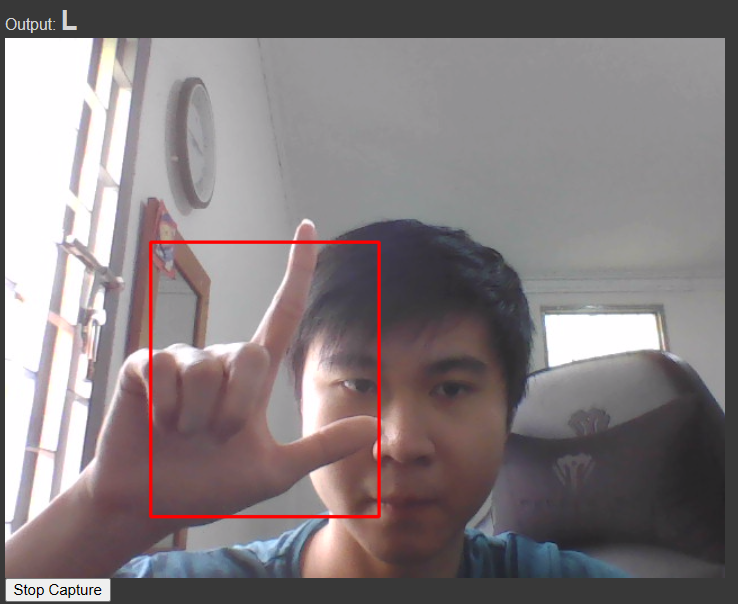

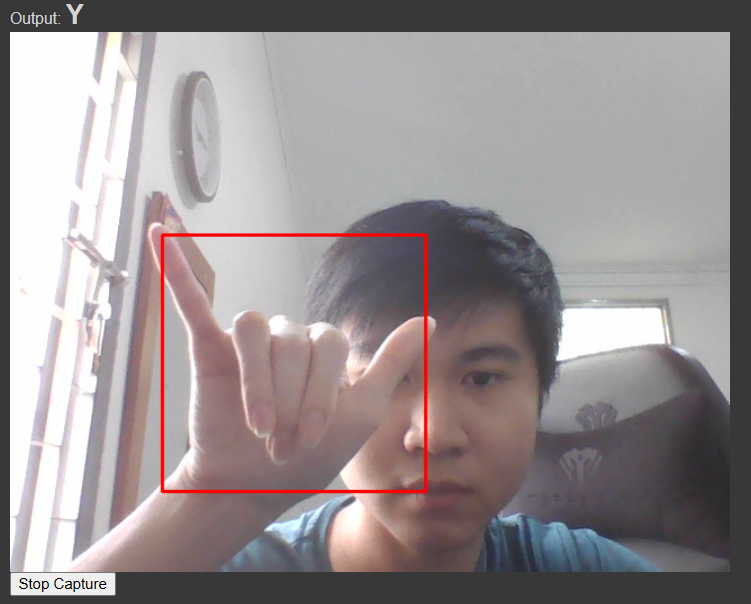

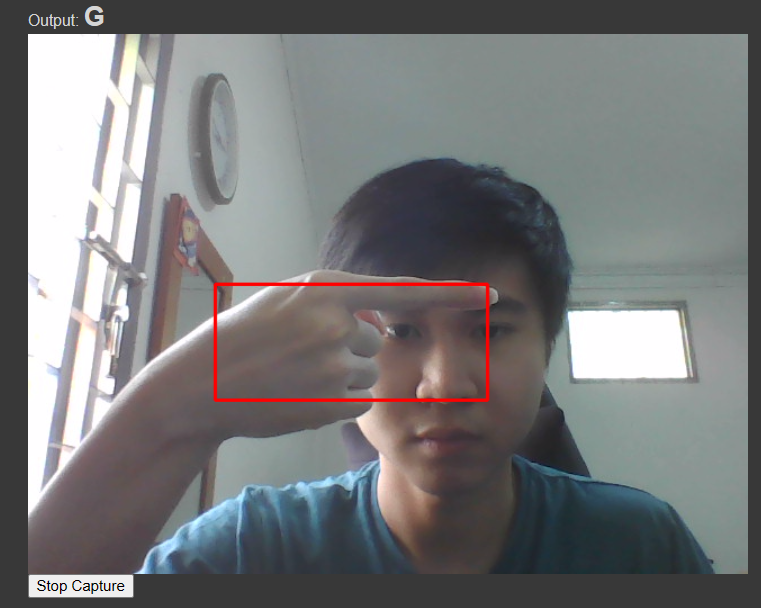